In [1]:
# Forces the notebook to always reload packages.
%reload_ext autoreload
%autoreload 2

## Dataset loading

### Regular dataset loading

In [2]:
from python_proj.utils.util import Counter
import python_proj.utils.exp_utils as exp_utils

# Defines a number of constants.

file_name = "dataset_transformed"
base_path = exp_utils.BASE_PATH
data_path = f"{base_path}/final_data/{file_name}.csv"
figure_base_path = f"{base_path}/figures/modelling/{file_name}/rf_full/"

# Meta stuff.
pr_merged_key = "PullRequestIsMerged"
ftc_key = "SubmitterIsFirstTimeContributor"
seed_counter = Counter()

In [3]:
import pandas as pd
import numpy as np
import json


# Loads regular dataframe.
df: pd.DataFrame = pd.read_csv(filepath_or_buffer=data_path, header=0)

# Creates sub-datasets.
metadata_fields = ["ID", "Project Name", "Submitter ID", "PR Number", "Closed At"]
dependent_fields = [pr_merged_key]

df.describe()

,ID,Project Name,Submitter ID,PR Number,Closed At,IntraProjectSubmitterPullRequestSuccessRate,EcosystemExperienceSubmitterPullRequestSuccessRate,DependencyEcosystemExperienceSubmitterPullRequestSuccessRate,NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,...,ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + NonDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + NonDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + WeightedEcosystemSecondOrderDegreeCentrality),ln(1 + WeightedIntraProjectSecondOrderDegreeCentrality),ln(1 + EcosystemLinkIntensity),ln(1 + IntraProjectLinkIntensity)
count,1.216221e+06,1.216221e+06,1216221.0,1216221.0,1216221.0,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,...,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06,1.216221e+06
mean,9.081164e+05,8.677039e+03,0.0,0.0,0.0,5.027905e-01,4.027001e-01,9.860918e-02,3.749753e-01,5.920373e-02,...,1.145965e-02,1.972030e-02,7.959556e-02,1.343719e-01,9.534855e-03,1.751229e-02,6.396949e-02,6.042839e-02,2.191224e-02,4.468485e-02
std,5.243531e+05,5.806587e+03,0.0,0.0,0.0,4.710578e-01,4.523420e-01,2.908001e-01,4.479160e-01,2.284681e-01,...,5.401390e-02,8.011601e-02,1.179346e-01,1.749533e-01,5.258916e-02,8.239552e-02,9.937732e-02,1.003326e-01,8.736962e-02,1.013914e-01
min,0.000000e+00,4.300000e+01,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.542500e+05,3.224000e+03,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,9.078700e+05,8.413000e+03,0.0,0.0,0.0,6.666667e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,7.753347e-02,0.000000e+00,0.000000e+00,8.438514e-03,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.362318e+06,1.357000e+04,0.0,0.0,0.0,1.000000e+00,9.387755e-01,0.000000e+00,9.230769e-01,0.000000e+00,...,0.000000e+00,0.000000e+00,1.416667e-01,2.326004e-01,0.000000e+00,0.000000e+00,9.891430e-02,8.847414e-02,0.000000e+00,2.582313e-02
max,1.815970e+06,2.009400e+04,0.0,0.0,0.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [4]:
print(list(df.columns))

['ID', 'Project Name', 'Submitter ID', 'PR Number', 'Closed At', 'PullRequestIsMerged', 'ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlPullRequestHasCommentByExternalUser', 'ControlHasHashTagInDescription', 'IntraProjectSubmitterPullRequestSuccessRate', 'EcosystemExperienceSubmitterPullRequestSuccessRate', 'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'SubmitterIsFirstTimeContributor', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)', 'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)', 'ln(1 + IntraProjectSubmitterPullRequestCommentCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystem

In [5]:
intra_collab_fields = [
    "ln(1 + WeightedIntraProjectSecondOrderDegreeCentrality)",
    "ln(1 + IntraProjectLinkIntensity)",
]

df = df.drop(intra_collab_fields, axis=1)

In [6]:
# Identifieds independent / predictor fields.


def is_independent_field(field: str) -> bool:
    return field not in metadata_fields and field != pr_merged_key


independent_fields = list(filter(is_independent_field, df.columns))

In [7]:
# Calculates class imbalance.
class_counts = df[pr_merged_key].value_counts()
class_imbalance = class_counts[True] / class_counts[False]
print(f"{class_imbalance=}")

class_imbalance=3.6988274383294377


## Model Creation

In [8]:
k = 5
print(f"Using {k=} folds.")

Using k=5 folds.


Generates a number of feature groups that are relevant later in the pipeline:
- control variables
- intra-project experience
- ecosystem experience
- dependency ecosystem experience
- inverse dependency ecosystem experience
- non-dependency ecosystem experience
- collaboration variables

In [9]:
from enum import Enum
from python_proj.utils.util import get_matching

# Defines feature groups


class FeatureGroups(Enum):
    Control = 1
    Intra = 2
    Eco = 3
    DEco = 4
    IDEco = 5
    NDEco = 6
    Coll = 7


var_group_regex_patterns = [
    (FeatureGroups.Control, r".*Control.*"),
    (
        FeatureGroups.Intra,
        r"^(?:(?!Control|Degree|Link).)*Intra(?:(?!Control|Degree|Link).)*$",
    ),
    (FeatureGroups.Eco, r"^(?:(?!Dependency).)*Ecosystem(?:(?!Degree|Link).)*$"),
    (FeatureGroups.DEco, r"^(?!.*(Inverse|Non)).*(?=Dependency).*"),
    (FeatureGroups.IDEco, r".*(?=Inverse).*"),
    (FeatureGroups.NDEco, r".*(?=NonDependency).*"),
    (FeatureGroups.Coll, r"^(?:(?!Intra).)*(Weighted|LinkIntensity)(?:(?!Intra).)*$"),
]

# Resolves the regex patterns to generate lists of fields.
var_groups = {
    str(name): list(get_matching(independent_fields, pattern))
    for name, pattern in var_group_regex_patterns
}


print("Feature groups:")
print(json.dumps(var_groups, indent=2))

Feature groups:
{
  "FeatureGroups.Control": [
    "ControlIntegratedBySameUser",
    "ControlPullRequestHasComments",
    "ControlPullRequestHasCommentByExternalUser",
    "ControlHasHashTagInDescription",
    "ln(1 + ControlPullRequestLifeTimeInMinutes)",
    "ln(1 + ControlNumberOfCommitsInPullRequest)",
    "ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)"
  ],
  "FeatureGroups.Intra": [
    "IntraProjectSubmitterPullRequestSuccessRate",
    "ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)",
    "ln(1 + IntraProjectSubmitterPullRequestCommentCount)",
    "ln(1 + IntraProjectSubmitterIssueSubmissionCount)",
    "ln(1 + IntraProjectSubmitterIssueCommentCount)"
  ],
  "FeatureGroups.Eco": [
    "EcosystemExperienceSubmitterPullRequestSuccessRate",
    "ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)",
    "ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)",
    "ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount)",
    "ln(1 + Ecosyst

In [10]:
from wmutils.collections.list_access import flatten


def get_feature_groups(*feature_groups) -> list[str]:
    return list(flatten(var_groups[str(group)] for group in feature_groups))

### Full Model

In [11]:
from python_proj.modelling.notebooks.random_forest.rf_functions import (
    kfold_rf_evaluation,
)

f1_scores, f1_mean, f1_std = kfold_rf_evaluation(
    df, independent_fields, k, pr_merged_key, seed_counter
)

print("\nPerformance metrics full model:")
print(f"{f1_scores=}")
print(f"{f1_mean=}, {f1_std=}")

random_state=43

random_state=43

random_state=43

random_state=43

random_state=43

metrics={'accuracy': 0.8722393974774301, 'precision': 0.8966394483221941, 'recall': 0.947027641835276, 'f1': 0.9211449798656697}


Confusion matrix:
[[ 30654  20924]
 [ 10153 181513]]


Classification report:

              precision    recall  f1-score   support

       False       0.75      0.59      0.66     51578
        True       0.90      0.95      0.92    191666

    accuracy                           0.87    243244
   macro avg       0.82      0.77      0.79    243244
weighted avg       0.87      0.87      0.87    243244


metrics={'accuracy': 0.8715816217460657, 'precision': 0.8959907375795989, 'recall': 0.9465975264241879, 'f1': 0.9205991728709816}


Confusion matrix:
[[ 30921  21021]
 [ 10216 181086]]


Classification report:

              precision    recall  f1-score   support

       False       0.75      0.60      0.66     51942
        True       0.90      0.95      0.92    191302

    accuracy                           0.87    243244
   macro avg       0.82      0.77      0.79    243244
weighted avg       0.87      0.87      0.87    243244


metrics={'accuracy': 0.8712121523566774, 'precision': 0.8966982577157596, 'recall': 0.945693693881486, 'f1': 0.9205444985809254}


Confusion matrix:
[[ 30446  20906]
 [ 10421 181472]]


Classification report:

              precision    recall  f1-score   support

       False       0.75      0.59      0.66     51352
        True       0.90      0.95      0.92    191893

    accuracy                           0.87    243245
   macro avg       0.82      0.77      0.79    243245
weighted avg       0.86      0.87      0.87    243245


metrics={'accuracy': 0.8713390669451251, 'precision': 0.895488063621122, 'recall': 0.9468490657797719, 'f1': 0.920452639124003}


Confusion matrix:
[[ 30883  21132]
 [ 10164 181065]]


Classification report:

              precision    recall  f1-score   support

       False       0.75      0.59      0.66     52015
        True       0.90      0.95      0.92    191229

    accuracy                           0.87    243244
   macro avg       0.82      0.77      0.79    243244
weighted avg       0.86      0.87      0.87    243244


metrics={'accuracy': 0.8716926214007334, 'precision': 0.8959897889518834, 'recall': 0.9467526764804283, 'f1': 0.9206720382278931}


Confusion matrix:
[[ 30924  21024]
 [ 10186 181110]]


Classification report:

              precision    recall  f1-score   support

       False       0.75      0.60      0.66     51948
        True       0.90      0.95      0.92    191296

    accuracy                           0.87    243244
   macro avg       0.82      0.77      0.79    243244
weighted avg       0.87      0.87      0.87    243244



Performance metrics full model:
f1_scores=[0.9211449798656697, 0.9205991728709816, 0.9205444985809254, 0.920452639124003, 0.9206720382278931]
f1_mean=0.9206826657338946, f1_std=0.00024200031483368793


### Control + Intra-project Model

In [12]:
contr_with_intra = get_feature_groups(FeatureGroups.Control, FeatureGroups.Intra)
print(contr_with_intra)

f1_scores, f1_mean, f1_std = kfold_rf_evaluation(
    df, contr_with_intra, k, pr_merged_key, seed_counter
)

print("\nPerformance metrics control + intra model:")
print(f"{f1_scores=}")
print(f"{f1_mean=}, {f1_std=}")

['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlPullRequestHasCommentByExternalUser', 'ControlHasHashTagInDescription', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)', 'IntraProjectSubmitterPullRequestSuccessRate', 'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)', 'ln(1 + IntraProjectSubmitterPullRequestCommentCount)', 'ln(1 + IntraProjectSubmitterIssueSubmissionCount)', 'ln(1 + IntraProjectSubmitterIssueCommentCount)']


random_state=45

random_state=45

random_state=45

random_state=45

random_state=45

metrics={'accuracy': 0.8551454506585979, 'precision': 0.8902557138720532, 'recall': 0.9308201051296373, 'f1': 0.9100861244019139}


Confusion matrix:
[[ 29689  21982]
 [ 13253 178320]]


Classification report:

              precision    recall  f1-score   support

       False       0.69      0.57      0.63     51671
        True       0.89      0.93      0.91    191573

    accuracy                           0.86    243244
   macro avg       0.79      0.75      0.77    243244
weighted avg       0.85      0.86      0.85    243244


metrics={'accuracy': 0.8549686734307937, 'precision': 0.8905354326766628, 'recall': 0.9298824316624236, 'f1': 0.9097837038855559}


Confusion matrix:
[[ 30086  21865]
 [ 13413 177880]]


Classification report:

metrics={'accuracy': 0.8556517091821003, 'precision': 0.8913602950362549, 'recall': 0.9302608178655805, 'f1': 0.9103951982115788}


Confusion matrix:
[[ 29762  21740]
 [ 13372 178371]]


Classification report:

              precision    recall  f1-score   support

       False       0.69      0.58      0.63     51951
        True       0.89      0.93      0.91    191293

    accuracy                           0.85    243244
   macro avg       0.79      0.75      0.77    243244
weighted avg       0.85      0.85      0.85    243244


              precision    recall  f1-score   support

       False       0.69      0.58      0.63     51502
        True       0.89      0.93      0.91    191743

    accuracy                           0.86    243245
   macro avg       0.79      0.75      0.77    243245
weighted avg       0.85      0.86      0.85    243245


metrics={'accuracy': 0.8551906727401293, 'precision': 0.8900337981198859, 'recall': 0.9310778840278466, 'f1': 0.9100933167255426}


Confusion matrix:
[[ 29740  22027]
 [ 13197 178280]]


Classification report:

metrics={'accuracy': 0.8550508953972143, 'precision': 0.8898477005176584, 'recall': 0.9309304756926294, 'f1': 0.909925606491038}


Confusion matrix:
[[ 29899  22045]
 [ 13213 178087]]


Classification report:

              precision    recall  f1-score   support

       False       0.69      0.57      0.63     51767
        True       0.89      0.93      0.91    191477

    accuracy                           0.86    243244
   macro avg       0.79      0.75      0.77    243244
weighted avg       0.85      0.86      0.85    243244


              precision    recall  f1-score   support

       False       0.69      0.58      0.63     51944
        True       0.89      0.93      0.91    191300

    accuracy                           0.86    243244
   macro avg       0.79      0.75      0.77    243244
weighted avg       0.85      0.86      0.85    243244



Performance metrics control + intra model:
f1_scores=[0.9100861244019139, 0.9097837038855559, 0.9103951982115788, 0.9100933167255426, 0.909925606491038]
f1_mean=0.9100567899431258, f1_std=0.00020420576162499224


### Collaboration and Ecosystem Model

In [13]:
non_control_intra_fields = get_feature_groups(
    FeatureGroups.Eco,
    FeatureGroups.DEco,
    FeatureGroups.IDEco,
    FeatureGroups.NDEco,
    FeatureGroups.Coll,
)
print(non_control_intra_fields)

f1_scores, f1_mean, f1_std = kfold_rf_evaluation(
    df, non_control_intra_fields, k, pr_merged_key, seed_counter
)

print("\nPerformance metrics non-control model:")
print(f"{f1_scores=}")
print(f"{f1_mean=}, {f1_std=}")

['EcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterIssueCommentCount)', 'DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount)', 'InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + InversedDependencyEcosyste

random_state=47

random_state=47

random_state=47

random_state=47

random_state=47

metrics={'accuracy': 0.7812361250431665, 'precision': 0.7970988961884342, 'recall': 0.9687216066337347, 'f1': 0.8745701186814222}


Confusion matrix:
[[  4515  47223]
 [  5990 185516]]


Classification report:

metrics={'accuracy': 0.7802083504629097, 'precision': 0.7961272202562958, 'recall': 0.9686998688425222, 'f1': 0.8739760836717906}


Confusion matrix:
[[  4398  47473]
 [  5990 185383]]


Classification report:

              precision    recall  f1-score   support

       False       0.43      0.09      0.15     51738
        True       0.80      0.97      0.87    191506

    accuracy                           0.78    243244
   macro avg       0.61      0.53      0.51    243244
weighted avg       0.72      0.78      0.72    243244


              precision    recall  f1-score   support

       False       0.42      0.08      0.14     51871
        True       0.80      0.97      0.87    191373

    accuracy                           0.78    243244
   macro avg       0.61      0.53      0.51    243244
weighted avg       0.72      0.78      0.72    243244


metrics={'accuracy': 0.7814384673888466, 'precision': 0.7977229275418358, 'recall': 0.9682775596197271, 'f1': 0.8747644353987638}


Confusion matrix:
[[  4407  47081]
 [  6083 185674]]


Classification report:

metrics={'accuracy': 0.78024946144612, 'precision': 0.7959807888926119, 'recall': 0.9688315355213829, 'f1': 0.873941414937045}


Confusion matrix:
[[  4501  47492]
 [  5961 185290]]


Classification report:

              precision    recall  f1-score   support

       False       0.42      0.09      0.14     51488
        True       0.80      0.97      0.87    191757

    accuracy                           0.78    243245
   macro avg       0.61      0.53      0.51    243245
weighted avg       0.72      0.78      0.72    243245


              precision    recall  f1-score   support

       False       0.43      0.09      0.14     51993
        True       0.80      0.97      0.87    191251

    accuracy                           0.78    243244
   macro avg       0.61      0.53      0.51    243244
weighted avg       0.72      0.78      0.72    243244


metrics={'accuracy': 0.7805865715084442, 'precision': 0.7968196664947568, 'recall': 0.9681721575569585, 'f1': 0.8741781182000995}


Confusion matrix:
[[  4469  47276]
 [  6095 185404]]


Classification report:

              precision    recall  f1-score   support

       False       0.42      0.09      0.14     51745
        True       0.80      0.97      0.87    191499

    accuracy                           0.78    243244
   macro avg       0.61      0.53      0.51    243244
weighted avg       0.72      0.78      0.72    243244



Performance metrics non-control model:
f1_scores=[0.8745701186814222, 0.8739760836717906, 0.8747644353987638, 0.873941414937045, 0.8741781182000995]
f1_mean=0.8742860341778241, f1_std=0.0003274291767497271


## Feature Explanation and Evaluation

### Model Creation

In [14]:
from sklearn.model_selection import train_test_split

from python_proj.modelling.notebooks.random_forest.rf_functions import create_model


train, test = train_test_split(df, test_size=0.2, shuffle=True)
train_predictors = train[independent_fields]
train_dependent = train[pr_merged_key]
test_predictors = test[independent_fields]
test_dependent = test[pr_merged_key]


full_rf_model, _ = create_model(
    train_predictors, train_dependent, test_predictors, test_dependent, seed_counter
)

random_state=49


metrics={'accuracy': 0.8712162634380974, 'precision': 0.8956435290975457, 'recall': 0.9465422612513721, 'f1': 0.9203897410874935}

Confusion matrix:
[[ 30836  21099]
 [ 10227 181083]]

Classification report:


              precision    recall  f1-score   support

       False       0.75      0.59      0.66     51935
        True       0.90      0.95      0.92    191310

    accuracy                           0.87    243245
   macro avg       0.82      0.77      0.79    243245
weighted avg       0.86      0.87      0.87    243245



### Mean decrease in Impurity

/tmp/ipykernel_107431/1648129876.py:16: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


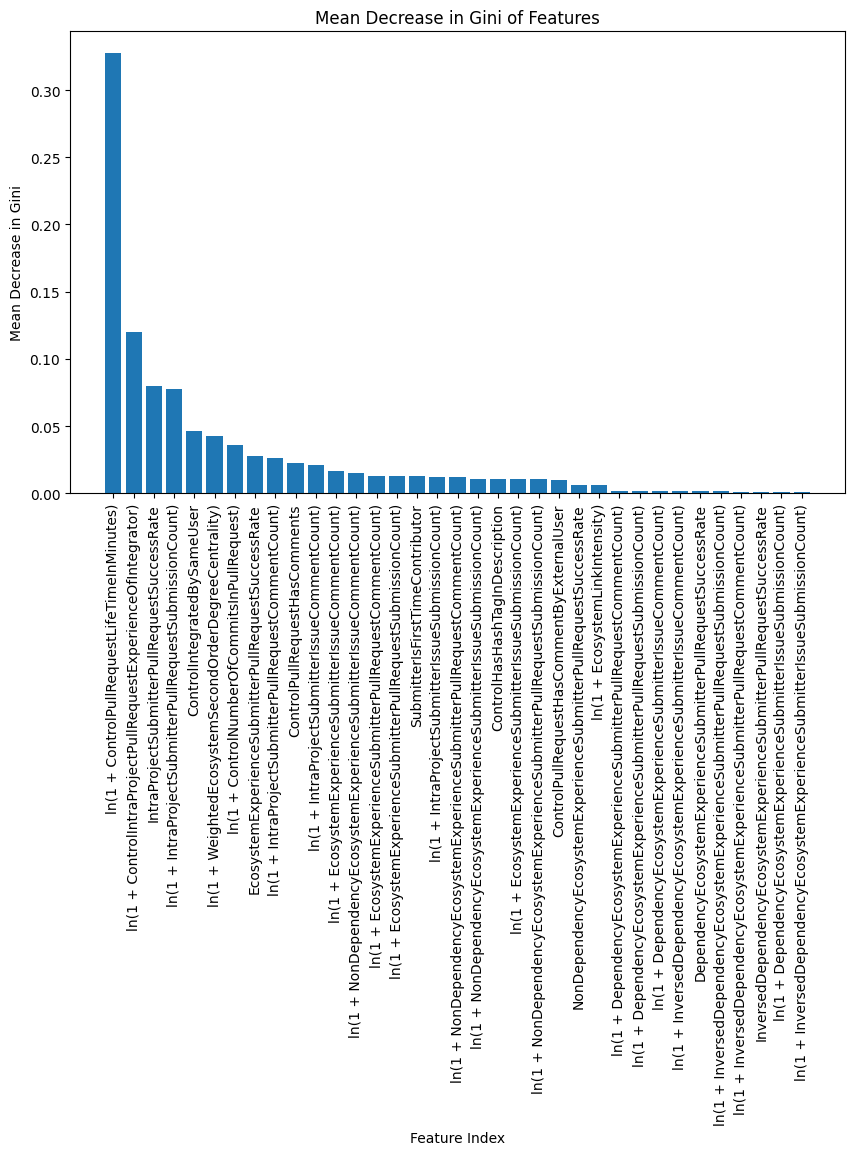

In [15]:
from matplotlib import pyplot as plt

feature_importances = full_rf_model.feature_importances_

sorted_indices = np.argsort(feature_importances)[::-1]
sorted_importances = feature_importances[sorted_indices]

# Step 4: Plot the mean decrease accuracy plot
plt.figure(figsize=(10, 6))
plt.bar(range(test_predictors.shape[1]), sorted_importances)
plt.xlabel("Feature Index")
plt.ylabel("Mean Decrease in Gini")
plt.title("Mean Decrease in Gini of Features")
ordererd_columns = np.array(test_predictors.columns)[sorted_indices]
plt.xticks(range(test_predictors.shape[1]), ordererd_columns, rotation=90)
plt.tight_layout()
plt.show()

In [16]:
# Stores feature importances in file.
output_file = f"{figure_base_path}/feature_importance.txt"
with open(output_file, "w+", encoding="utf-8") as output_file:
    for field, importance in zip(ordererd_columns, sorted_importances):
        entry = f"{field}: {importance}"
        output_file.write(f'{entry}\n')
        print(entry)

ln(1 + ControlPullRequestLifeTimeInMinutes): 0.3272921354725626
ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator): 0.12023013551476548
IntraProjectSubmitterPullRequestSuccessRate: 0.08000833712269222
ln(1 + IntraProjectSubmitterPullRequestSubmissionCount): 0.07730722403674559
ControlIntegratedBySameUser: 0.04615364668664301
ln(1 + WeightedEcosystemSecondOrderDegreeCentrality): 0.04229663814976791
ln(1 + ControlNumberOfCommitsInPullRequest): 0.03559878636704602
EcosystemExperienceSubmitterPullRequestSuccessRate: 0.02772298146822082
ln(1 + IntraProjectSubmitterPullRequestCommentCount): 0.02596050013572065
ControlPullRequestHasComments: 0.02294409488036156
ln(1 + IntraProjectSubmitterIssueCommentCount): 0.020922803305446745
ln(1 + EcosystemExperienceSubmitterIssueCommentCount): 0.016348645870762294
ln(1 + NonDependencyEcosystemExperienceSubmitterIssueCommentCount): 0.015357485811615739
ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount): 0.01295638821721082
ln(1 + Ecosy

### Variable Group Reverse Ablation Studies

Creates a model with a subset of features.
Compared to regular ablation, it tests "what happens if I add a feature", instead of "what happens when I remove one".

In [17]:
rev_abl_results = dict()

for cluster_name, cluster in var_groups.items():
    print(f'Reverse ablation with "{str(cluster_name)}", including: {cluster}.')

    # Creates models
    f1_scores, f1_mean, f1_std = kfold_rf_evaluation(
        df, cluster, k, pr_merged_key, seed_counter
    )
    rev_abl_results[cluster_name] = (f1_scores, f1_mean, f1_std)

    print(
        f"Performance of '{cluster_name}'\n{list(cluster)}\n{f1_scores=}\n{f1_mean=}, {f1_std=}\n"
    )

Reverse ablation with "FeatureGroups.Control", including: ['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlPullRequestHasCommentByExternalUser', 'ControlHasHashTagInDescription', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)'].


random_state=50

random_state=50

random_state=50

random_state=50

random_state=50

metrics={'accuracy': 0.7994811793918863, 'precision': 0.84982222113239, 'recall': 0.9051745753149878, 'f1': 0.8766254954583511}


Confusion matrix:
[[ 21186  30622]
 [ 18153 173283]]


Classification report:

              precision    recall  f1-score   support

       False       0.54      0.41      0.46     51808
        True       0.85      0.91      0.88    191436

    accuracy                           0.80    243244
   macro avg       0.69      0.66      0.67    243244
weighted avg       0.78      0.80      0.79    243244


metrics={'accuracy': 0.8002499547779185, 'precision': 0.8508267221742204, 'recall': 0.9049563473829316, 'f1': 0.8770571445922147}


Confusion matrix:
[[ 21346  30386]
 [ 18202 173310]]


Classification report:

              precision    recall  f1-score   support

       False       0.54      0.41      0.47     51732
        True       0.85      0.90      0.88    191512

    accuracy                           0.80    243244
   macro avg       0.70      0.66      0.67    243244
weighted avg       0.78      0.80      0.79    243244


metrics={'accuracy': 0.8005007317755012, 'precision': 0.850837758517457, 'recall': 0.9053049885377992, 'f1': 0.8772267157823898}


Confusion matrix:
[[ 21352  30393]
 [ 18134 173365]]


Classification report:

metrics={'accuracy': 0.7990421180291476, 'precision': 0.8496940349085051, 'recall': 0.9044539704114172, 'f1': 0.8762192713239539}


Confusion matrix:
[[ 21350  30605]
 [ 18277 173013]]


Classification report:

              precision    recall  f1-score   support

       False       0.54      0.41      0.47     51745
        True       0.85      0.91      0.88    191499

    accuracy                           0.80    243244
   macro avg       0.70      0.66      0.67    243244
weighted avg       0.78      0.80      0.79    243244


              precision    recall  f1-score   support

       False       0.54      0.41      0.47     51955
        True       0.85      0.90      0.88    191290

    accuracy                           0.80    243245
   macro avg       0.69      0.66      0.67    243245
weighted avg       0.78      0.80      0.79    243245


metrics={'accuracy': 0.7998429560441368, 'precision': 0.8511441006847902, 'recall': 0.9040694185724945, 'f1': 0.8768088255759523}


Confusion matrix:
[[ 21293  30302]
 [ 18385 173264]]


Classification report:

              precision    recall  f1-score   support

       False       0.54      0.41      0.47     51595
        True       0.85      0.90      0.88    191649

    accuracy                           0.80    243244
   macro avg       0.69      0.66      0.67    243244
weighted avg       0.78      0.80      0.79    243244


Performance of 'FeatureGroups.Control'
['ControlIntegratedBySameUser', 'ControlPullRequestHasComments', 'ControlPullRequestHasCommentByExternalUser', 'ControlHasHashTagInDescription', 'ln(1 + ControlPullRequestLifeTimeInMinutes)', 'ln(1 + ControlNumberOfCommitsInPullRequest)', 'ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)']
f1_scores=[0.8766254954583511, 0.8770571445922147, 0.8772267157823898, 0.8762192713239539, 0.8768088255759523]
f1_mean=0.8767874905465722, f1_std=0.00035077137544265997

Reverse ablation with "FeatureGroups.Intra", including: ['IntraProjectSubmitterPullRequestSuccessRate', 'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)', 'ln(1 + IntraProjectSubmitterPullRequestCommentCount)', 'ln(1 + IntraProjectSubmitterIssueSubmissionCount)', 'ln(1 + IntraProjectSubmitterIssueCommentCount)'].


random_state=52

random_state=52

random_state=52

random_state=52

random_state=52

metrics={'accuracy': 0.7914645376658829, 'precision': 0.8000349529626899, 'recall': 0.9800889807939343, 'f1': 0.8809560129827765}


Confusion matrix:
[[  4830  46912]
 [  3813 187689]]


Classification report:

              precision    recall  f1-score   support

       False       0.56      0.09      0.16     51742
        True       0.80      0.98      0.88    191502

    accuracy                           0.79    243244
   macro avg       0.68      0.54      0.52    243244
weighted avg       0.75      0.79      0.73    243244


metrics={'accuracy': 0.7911068721119534, 'precision': 0.7995124300503339, 'recall': 0.9802939962270658, 'f1': 0.8807218847125324}


Confusion matrix:
[[  4840  47041]
 [  3771 187592]]


Classification report:

metrics={'accuracy': 0.791497426452451, 'precision': 0.7998738449998295, 'recall': 0.9803538500916751, 'f1': 0.880965289659656}


Confusion matrix:
[[  4851  46956]
 [  3761 187676]]


Classification report:

              precision    recall  f1-score   support

       False       0.56      0.09      0.16     51881
        True       0.80      0.98      0.88    191363

    accuracy                           0.79    243244
   macro avg       0.68      0.54      0.52    243244
weighted avg       0.75      0.79      0.73    243244


metrics={'accuracy': 0.7912762852268289, 'precision': 0.7996667646770558, 'recall': 0.9803621431855226, 'f1': 0.8808430242791931}


Confusion matrix:
[[  4817  47012]
 [  3759 187657]]


Classification report:

metrics={'accuracy': 0.7925580898192761, 'precision': 0.8007146842484103, 'recall': 0.980857524469395, 'f1': 0.8816785748621783}


Confusion matrix:
[[  4786  46790]
 [  3669 187999]]


Classification report:

              precision    recall  f1-score   support

       False       0.56      0.09      0.16     51807
        True       0.80      0.98      0.88    191437

    accuracy                           0.79    243244
   macro avg       0.68      0.54      0.52    243244
weighted avg       0.75      0.79      0.73    243244


              precision    recall  f1-score   support

       False       0.56      0.09      0.16     51829
        True       0.80      0.98      0.88    191416

    accuracy                           0.79    243245
   macro avg       0.68      0.54      0.52    243245
weighted avg       0.75      0.79      0.73    243245


              precision    recall  f1-score   support

       False       0.57      0.09      0.16     51576
        True       0.80      0.98      0.88    191668

    accuracy                           0.79    243244
   macro avg       0.68      0.54      0.52    243244
weighted avg       0.75      0.79      0.73    243244


Performance of 'FeatureGroups.Intra'
['IntraProjectSubmitterPullRequestSuccessRate', 'ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)', 'ln(1 + IntraProjectSubmitterPullRequestCommentCount)', 'ln(1 + IntraProjectSubmitterIssueSubmissionCount)', 'ln(1 + IntraProjectSubmitterIssueCommentCount)']
f1_scores=[0.8809560129827765, 0.8807218847125324, 0.880965289659656, 0.8808430242791931, 0.8816785748621783]
f1_mean=0.8810329572992673, f1_std=0.0003347124381203381

Reverse ablation with "FeatureGroups.Eco", including: ['EcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterIssueCommentCount)'].


random_state=54

random_state=54

random_state=54

random_state=54

random_state=54

metrics={'accuracy': 0.7829052309615037, 'precision': 0.7928915876326968, 'recall': 0.9803687131587053, 'f1': 0.8767196841827576}


Confusion matrix:
[[  2666  49047]
 [  3760 187771]]


Classification report:

metrics={'accuracy': 0.7822392330334972, 'precision': 0.7920789990972978, 'recall': 0.980789018714776, 'f1': 0.8763905451100185}


Confusion matrix:
[[  2500  49291]
 [  3678 187775]]


Classification report:

              precision    recall  f1-score   support

       False       0.41      0.05      0.09     51713
        True       0.79      0.98      0.88    191531

    accuracy                           0.78    243244
   macro avg       0.60      0.52      0.48    243244
weighted avg       0.71      0.78      0.71    243244


              precision    recall  f1-score   support

       False       0.40      0.05      0.09     51791
        True       0.79      0.98      0.88    191453

    accuracy                           0.78    243244
   macro avg       0.60      0.51      0.48    243244
weighted avg       0.71      0.78      0.71    243244


metrics={'accuracy': 0.7823748992780911, 'precision': 0.7925853988092725, 'recall': 0.9800858387026034, 'f1': 0.8764193933960854}


Confusion matrix:
[[  2600  49122]
 [  3814 187708]]


Classification report:

metrics={'accuracy': 0.7824447879495486, 'precision': 0.7923554940137456, 'recall': 0.980498686155791, 'f1': 0.876443792770938}


Confusion matrix:
[[  2635  49186]
 [  3733 187690]]


Classification report:

              precision    recall  f1-score   support

       False       0.41      0.05      0.09     51722
        True       0.79      0.98      0.88    191522

    accuracy                           0.78    243244
   macro avg       0.60      0.52      0.48    243244
weighted avg       0.71      0.78      0.71    243244


              precision    recall  f1-score   support

       False       0.41      0.05      0.09     51821
        True       0.79      0.98      0.88    191423

    accuracy                           0.78    243244
   macro avg       0.60      0.52      0.48    243244
weighted avg       0.71      0.78      0.71    243244


metrics={'accuracy': 0.783300787272092, 'precision': 0.792621713051621, 'recall': 0.981473646824091, 'f1': 0.8769960632953042}


Confusion matrix:
[[  2624  49164]
 [  3547 187910]]


Classification report:

              precision    recall  f1-score   support

       False       0.43      0.05      0.09     51788
        True       0.79      0.98      0.88    191457

    accuracy                           0.78    243245
   macro avg       0.61      0.52      0.48    243245
weighted avg       0.71      0.78      0.71    243245


Performance of 'FeatureGroups.Eco'
['EcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + EcosystemExperienceSubmitterIssueCommentCount)']
f1_scores=[0.8767196841827576, 0.8763905451100185, 0.8764193933960854, 0.876443792770938, 0.8769960632953042]
f1_mean=0.8765938957510209, f1_std=0.00023319302002313452

Reverse ablation with "FeatureGroups.DEco", including: ['DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount)'].


random_state=56

random_state=56

random_state=56

random_state=56

random_state=56

metrics={'accuracy': 0.7872547729851507, 'precision': 0.7882331121460661, 'recall': 0.9980795023406065, 'f1': 0.8808304950868975}


Confusion matrix:
[[   246  51381]
 [   368 191249]]


Classification report:

metrics={'accuracy': 0.7861826553474892, 'precision': 0.7872510584268088, 'recall': 0.9978993682428372, 'f1': 0.880146930046918}


Confusion matrix:
[[   266  51608]
 [   402 190969]]


Classification report:

              precision    recall  f1-score   support

       False       0.40      0.00      0.01     51627
        True       0.79      1.00      0.88    191617

    accuracy                           0.79    243244
   macro avg       0.59      0.50      0.45    243244
weighted avg       0.71      0.79      0.70    243244


metrics={'accuracy': 0.7854253342322935, 'precision': 0.7863806815840442, 'recall': 0.9981431694789368, 'f1': 0.8796974111225844}


Confusion matrix:
[[   219  51839]
 [   355 190831]]


Classification report:

              precision    recall  f1-score   support

       False       0.40      0.01      0.01     51874
        True       0.79      1.00      0.88    191371

    accuracy                           0.79    243245
   macro avg       0.59      0.50      0.45    243245
weighted avg       0.70      0.79      0.69    243245


metrics={'accuracy': 0.7876453273256483, 'precision': 0.7885662469344434, 'recall': 0.9981374722838138, 'f1': 0.8810610421607683}


Confusion matrix:
[[   272  51297]
 [   357 191318]]


Classification report:

metrics={'accuracy': 0.7869875515942839, 'precision': 0.7878832832659587, 'recall': 0.9982301069767199, 'f1': 0.8806706432371434}


Confusion matrix:
[[   232  51475]
 [   339 191198]]


Classification report:

              precision    recall  f1-score   support

       False       0.38      0.00      0.01     52058
        True       0.79      1.00      0.88    191186

    accuracy                           0.79    243244
   macro avg       0.58      0.50      0.44    243244
weighted avg       0.70      0.79      0.69    243244


              precision    recall  f1-score   support

       False       0.43      0.01      0.01     51569
        True       0.79      1.00      0.88    191675

    accuracy                           0.79    243244
   macro avg       0.61      0.50      0.45    243244
weighted avg       0.71      0.79      0.70    243244


              precision    recall  f1-score   support

       False       0.41      0.00      0.01     51707
        True       0.79      1.00      0.88    191537

    accuracy                           0.79    243244
   macro avg       0.60      0.50      0.44    243244
weighted avg       0.71      0.79      0.70    243244


Performance of 'FeatureGroups.DEco'
['DependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount)']
f1_scores=[0.8808304950868975, 0.880146930046918, 0.8796974111225844, 0.8810610421607683, 0.8806706432371434]
f1_mean=0.8804813043308624, f1_std=0.0004939988017604451

Reverse ablation with "FeatureGroups.IDEco", including: ['InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount)'

random_state=58

random_state=58

random_state=58

random_state=58

random_state=58

metrics={'accuracy': 0.7869267610845033, 'precision': 0.7878660501611321, 'recall': 0.998156994805127, 'f1': 0.8806314242744586}


Confusion matrix:
[[   234  51476]
 [   353 191182]]


Classification report:

              precision    recall  f1-score   support

       False       0.40      0.00      0.01     51710
        True       0.79      1.00      0.88    191535

    accuracy                           0.79    243245
   macro avg       0.59      0.50      0.44    243245
weighted avg       0.71      0.79      0.70    243245


metrics={'accuracy': 0.7856021114600977, 'precision': 0.7864675411376365, 'recall': 0.998247724657391, 'f1': 0.879792366327756}


Confusion matrix:
[[   248  51816]
 [   335 190845]]


Classification report:

metrics={'accuracy': 0.7853225567742678, 'precision': 0.7862125800935369, 'recall': 0.9982421077964612, 'f1': 0.8796306327695858}


Confusion matrix:
[[   223  51883]
 [   336 190802]]


Classification report:

metrics={'accuracy': 0.7882619920738024, 'precision': 0.7892897327997296, 'recall': 0.9980196265432582, 'f1': 0.8814664794826356}


Confusion matrix:
[[   237  51124]
 [   380 191503]]


Classification report:

metrics={'accuracy': 0.7872054398052983, 'precision': 0.788234809305009, 'recall': 0.9980537438038091, 'f1': 0.8808215235485765}


Confusion matrix:
[[   206  51388]
 [   373 191277]]


Classification report:

              precision    recall  f1-score   support

       False       0.43      0.00      0.01     52064
        True       0.79      1.00      0.88    191180

    accuracy                           0.79    243244
   macro avg       0.61      0.50      0.44    243244
weighted avg       0.71      0.79      0.69    243244


              precision    recall  f1-score   support

       False       0.40      0.00      0.01     52106
        True       0.79      1.00      0.88    191138

    accuracy                           0.79    243244
   macro avg       0.59      0.50      0.44    243244
weighted avg       0.70      0.79      0.69    243244


              precision    recall  f1-score   support

       False       0.38      0.00      0.01     51361
        True       0.79      1.00      0.88    191883

    accuracy                           0.79    243244
   macro avg       0.59      0.50      0.45    243244
weighted avg       0.70      0.79      0.70    243244


              precision    recall  f1-score   support

       False       0.36      0.00      0.01     51594
        True       0.79      1.00      0.88    191650

    accuracy                           0.79    243244
   macro avg       0.57      0.50      0.44    243244
weighted avg       0.70      0.79      0.70    243244


Performance of 'FeatureGroups.IDEco'
['InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount)']
f1_scores=[0.8806314242744586, 0.879792366327756, 0.8796306327695858, 0.8814664794826356, 0.8808215235485765]
f1_mean=0.8804684852806025, f1_std=0.0006791629009714507

Reverse ablation with "FeatureGroups.NDEco", including: ['NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + NonDependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + NonDependencyEcosystemExperienceSubmitterIss

random_state=60

random_state=60

random_state=60

random_state=60

random_state=60

metrics={'accuracy': 0.7828600088799724, 'precision': 0.7923117767532807, 'recall': 0.9815503163697872, 'f1': 0.8768369064885764}


Confusion matrix:
[[  2412  49284]
 [  3534 188014]]


Classification report:

              precision    recall  f1-score   support

       False       0.41      0.05      0.08     51696
        True       0.79      0.98      0.88    191548

    accuracy                           0.78    243244
   macro avg       0.60      0.51      0.48    243244
weighted avg       0.71      0.78      0.71    243244


metrics={'accuracy': 0.7828650126415754, 'precision': 0.7920432853368393, 'recall': 0.9818885626821853, 'f1': 0.8768073518607065}


Confusion matrix:
[[  2469  49350]
 [  3467 187959]]


Classification report:

              precision    recall  f1-score   support

       False       0.42      0.05      0.09     51819
        True       0.79      0.98      0.88    191426

    accuracy                           0.78    243245
   macro avg       0.60      0.51      0.48    243245
weighted avg       0.71      0.78      0.71    243245


metrics={'accuracy': 0.7831971189422966, 'precision': 0.7920456076529238, 'recall': 0.9825237647550402, 'f1': 0.877061944592087}


Confusion matrix:
[[  2394  49390]
 [  3346 188114]]


Classification report:

metrics={'accuracy': 0.7826338984723159, 'precision': 0.7918617440444334, 'recall': 0.98180678196353, 'f1': 0.8766635019792903}


Confusion matrix:
[[  2463  49391]
 [  3482 187908]]


Classification report:

metrics={'accuracy': 0.7827325648320205, 'precision': 0.7922057677318785, 'recall': 0.9815829861872396, 'f1': 0.8767850190130025}


Confusion matrix:
[[  2361  49321]
 [  3528 188034]]


Classification report:

              precision    recall  f1-score   support

       False       0.42      0.05      0.08     51784
        True       0.79      0.98      0.88    191460

    accuracy                           0.78    243244
   macro avg       0.60      0.51      0.48    243244
weighted avg       0.71      0.78      0.71    243244


              precision    recall  f1-score   support

       False       0.41      0.05      0.09     51854
        True       0.79      0.98      0.88    191390

    accuracy                           0.78    243244
   macro avg       0.60      0.51      0.48    243244
weighted avg       0.71      0.78      0.71    243244


              precision    recall  f1-score   support

       False       0.40      0.05      0.08     51682
        True       0.79      0.98      0.88    191562

    accuracy                           0.78    243244
   macro avg       0.60      0.51      0.48    243244
weighted avg       0.71      0.78      0.71    243244


Performance of 'FeatureGroups.NDEco'
['NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate', 'ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)', 'ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestCommentCount)', 'ln(1 + NonDependencyEcosystemExperienceSubmitterIssueSubmissionCount)', 'ln(1 + NonDependencyEcosystemExperienceSubmitterIssueCommentCount)']
f1_scores=[0.8768369064885764, 0.8768073518607065, 0.877061944592087, 0.8766635019792903, 0.8767850190130025]
f1_mean=0.8768309447867326, f1_std=0.00012969144040989093

Reverse ablation with "FeatureGroups.Coll", including: ['ln(1 + WeightedEcosystemSecondOrderDegreeCentrality)', 'ln(1 + EcosystemLinkIntensity)'].


random_state=62

random_state=62

random_state=62

random_state=62

random_state=62

metrics={'accuracy': 0.7641216227327293, 'precision': 0.7915977505788951, 'recall': 0.9503772914445768, 'f1': 0.8637512110792379}


Confusion matrix:
[[  4000  47880]
 [  9496 181868]]


Classification report:

              precision    recall  f1-score   support

       False       0.30      0.08      0.12     51880
        True       0.79      0.95      0.86    191364

    accuracy                           0.76    243244
   macro avg       0.54      0.51      0.49    243244
weighted avg       0.69      0.76      0.71    243244


metrics={'accuracy': 0.7644011774185592, 'precision': 0.7915232928914159, 'recall': 0.9509556437071763, 'f1': 0.8639456428323844}


Confusion matrix:
[[  3983  47924]
 [  9384 181953]]


Classification report:

              precision    recall  f1-score   support

       False       0.30      0.08      0.12     51907
        True       0.79      0.95      0.86    191337

    accuracy                           0.76    243244
   macro avg       0.54      0.51      0.49    243244
weighted avg       0.69      0.76      0.71    243244


metrics={'accuracy': 0.7656632846031146, 'precision': 0.7935065613598168, 'recall': 0.950089925713541, 'f1': 0.8647672733052908}


Confusion matrix:
[[  3992  47427]
 [  9574 182251]]


Classification report:

              precision    recall  f1-score   support

       False       0.29      0.08      0.12     51419
        True       0.79      0.95      0.86    191825

    accuracy                           0.77    243244
   macro avg       0.54      0.51      0.49    243244
weighted avg       0.69      0.77      0.71    243244


metrics={'accuracy': 0.7631030442557915, 'precision': 0.7908688286860224, 'recall': 0.9497879283924919, 'f1': 0.8630738522954092}


Confusion matrix:
[[  4013  48023]
 [  9601 181608]]


Classification report:

              precision    recall  f1-score   support

       False       0.29      0.08      0.12     52036
        True       0.79      0.95      0.86    191209

    accuracy                           0.76    243245
   macro avg       0.54      0.51      0.49    243245
weighted avg       0.68      0.76      0.70    243245


metrics={'accuracy': 0.7654659518837053, 'precision': 0.792890652879686, 'recall': 0.9506446613897136, 'f1': 0.864630914048022}


Confusion matrix:
[[  4003  47590]
 [  9459 182192]]


Classification report:

              precision    recall  f1-score   support

       False       0.30      0.08      0.12     51593
        True       0.79      0.95      0.86    191651

    accuracy                           0.77    243244
   macro avg       0.55      0.51      0.49    243244
weighted avg       0.69      0.77      0.71    243244


Performance of 'FeatureGroups.Coll'
['ln(1 + WeightedEcosystemSecondOrderDegreeCentrality)', 'ln(1 + EcosystemLinkIntensity)']
f1_scores=[0.8637512110792379, 0.8639456428323844, 0.8647672733052908, 0.8630738522954092, 0.864630914048022]
f1_mean=0.8640337787120689, f1_std=0.0006170342054606149



In [18]:
# Prints summarized results again for clarity.
print("Reverse cluster ablation results:")
for cluster_name, (f1_scores, f1_mean, f1_std) in rev_abl_results.items():
    print(f"Cluster '{cluster_name}':\n{f1_scores=}\n{f1_mean=}, {f1_std=}\n")

Reverse cluster ablation results:
Cluster 'FeatureGroups.Control':
f1_scores=[0.8766254954583511, 0.8770571445922147, 0.8772267157823898, 0.8762192713239539, 0.8768088255759523]
f1_mean=0.8767874905465722, f1_std=0.00035077137544265997

Cluster 'FeatureGroups.Intra':
f1_scores=[0.8809560129827765, 0.8807218847125324, 0.880965289659656, 0.8808430242791931, 0.8816785748621783]
f1_mean=0.8810329572992673, f1_std=0.0003347124381203381

Cluster 'FeatureGroups.Eco':
f1_scores=[0.8767196841827576, 0.8763905451100185, 0.8764193933960854, 0.876443792770938, 0.8769960632953042]
f1_mean=0.8765938957510209, f1_std=0.00023319302002313452

Cluster 'FeatureGroups.DEco':
f1_scores=[0.8808304950868975, 0.880146930046918, 0.8796974111225844, 0.8810610421607683, 0.8806706432371434]
f1_mean=0.8804813043308624, f1_std=0.0004939988017604451

Cluster 'FeatureGroups.IDEco':
f1_scores=[0.8806314242744586, 0.879792366327756, 0.8796306327695858, 0.8814664794826356, 0.8808215235485765]
f1_mean=0.8804684852806025,

### Probability Guesser

Guesses the outcome by simply considering the probability of a merged pull request.
Technically, an RF model performs somewhat well when its performance scores are ``> 0.5`` as there are only two possible outcomes.
However, they actually mean anything once it's better than a simple probability guesser.

In [19]:
import random

from python_proj.modelling.notebooks.random_forest.rf_functions import calculate_metrics

random.seed(seed_counter.get_next())

probability_true = class_imbalance / (class_imbalance + 1)

predictions = [random.random() < probability_true for _ in range(len(test_dependent))]
metrics = calculate_metrics(predictions, test_dependent)

print(f"Probability guesser metrics with {probability_true=}.")
print(json.dumps(metrics, indent=4))

Probability guesser metrics with probability_true=0.7871809481993814.
{
    "accuracy": 0.665316861600444,
    "precision": 0.786397798463511,
    "recall": 0.7886832889028279,
    "f1": 0.7875388855251894
}


In [20]:
import datetime

print(datetime.datetime.now())

2024-02-21 18:20:27.708117
